<a href="https://colab.research.google.com/github/AlfonsoRafel/Posgrado-IA---UBA/blob/master/11.%20Analisis%20de%20Datos/TP_Integrador_An%C3%A1lisis_de_datos5_Alfonso_Rafel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos - Trabajo final integrador

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQATNC-EBwF-LIbDVv_L0gkP2V6oKQzah5GRg&usqp=CAU"/>

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado.

Trabajaremos con un [dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv).

El objetivo es predecir si lloverá o no al día siguiente (variable *RainTomorrow*), en función datos metereológicos del día actual.


## Carga de Datos

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install funpymodeling

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import funpymodeling as fp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
file_path = '/content/gdrive/MyDrive/Alfonso/CEIA/Bimestre V/Análisis de Datos/weatherAUS.csv'

In [ ]:
data = pd.read_csv(file_path)

In [ ]:
fp.status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Date,0,0.000000,0,0.000000,3436,object
1,Location,0,0.000000,0,0.000000,49,object
2,MinTemp,1485,0.010209,159,0.001093,389,float64
3,MaxTemp,1261,0.008669,14,0.000096,505,float64
4,Rainfall,3261,0.022419,91080,0.626152,681,float64
5,Evaporation,62790,0.431665,244,0.001677,358,float64
6,Sunshine,69835,0.480098,2359,0.016218,145,float64
7,WindGustDir,10326,0.070989,0,0.000000,16,object
8,WindGustSpeed,10263,0.070555,0,0.000000,67,float64
9,WindDir9am,10566,0.072639,0,0.000000,16,object


### 1. Análisis exploratorio inicial

- Realizar un resumen de 5 números. ??




In [ ]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
data.Rainfall.value_counts()

0.0      91080
0.2       8761
0.4       3782
0.6       2592
0.8       2056
         ...  
106.0        1
170.4        1
90.0         1
172.2        1
74.4         1
Name: Rainfall, Length: 681, dtype: int64

Para clasificar las variables por tipo de datos se utiliza el método status, de donde se conoce el type (object, float64 o int32/64) y la cantidad de valores únicos. Luego utilizamos también el método value_counts() para validar que los valores únicos de ciertas variables sean enteros, más allá de haber sido levantados como float64.
A continuación la clasificación:

- Fecha/Hora: Date 
- Numéricas:
    - Discretas: Cloud9am, Cloud3pm
    - Continuas: MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm
- Categóricas:
    - Nominales: Location, WindGustDir, WindDir9pm, WindDir3pm, RainToday, RainTomorrow
    - Ordinales: N/A

Clasificacion de variables:

- Variables de Entrada: Date, Location, Cloud9am, Cloud3pm, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity3pm, Pressure9am, Pressure3pm, Temp9am, Temp3pm, WindGustDir, WindDir9pm, WindDir3pm, RainToday

- Variable de Salida: RainTomorrow



La unica variable compuesta Date, podria ser dividida en año, mes y dia, convirtiendose en variables numericas discretas. Si permanece como un string, entonces seria lo mismo que un id, ya que no habria dos observaciones para el mismo dia, lo cual no agregaria valor al modelo. Otra opcion mas compleja seria entrenar un embedding de la fecha, de manera de tener una variable en vez de tres.

Todas las variables de entrada podrian ser informativas para un problema de clasificacion. Rainfall y Evaporation presentan una gran cantidad de valores 0, por lo cual podrian ser dos variables a prescindir, en caso que se confirme que no presenta relacion con la salida (a revisarse en analisis posteriores).

#### Variables de Entrada

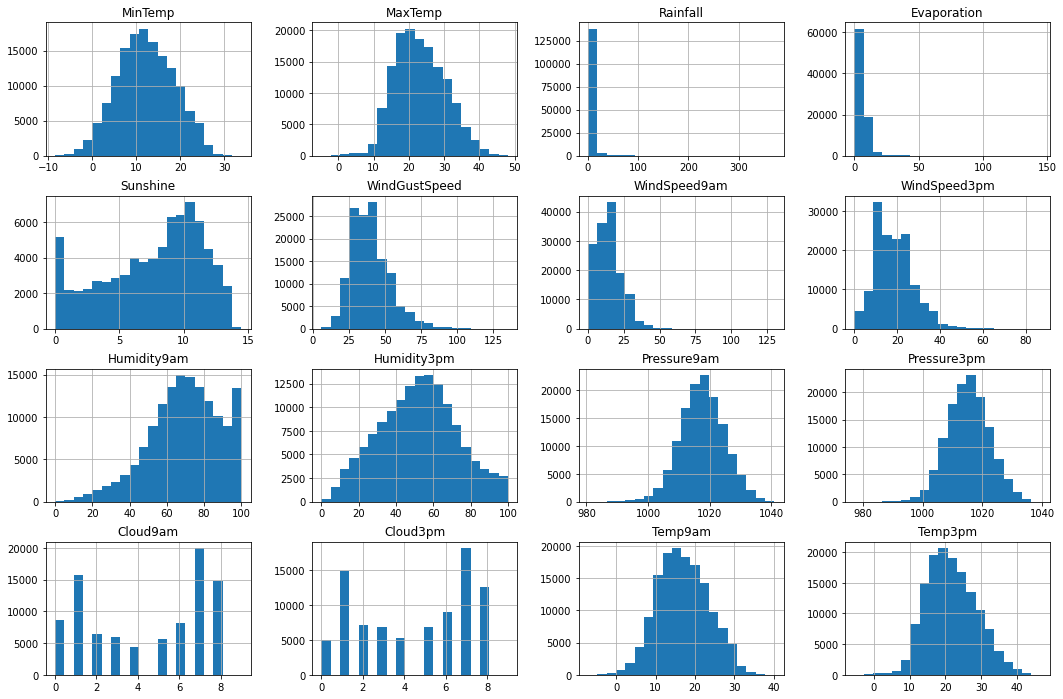

In [ ]:
hist = data.hist(bins=20, figsize=(18,12))

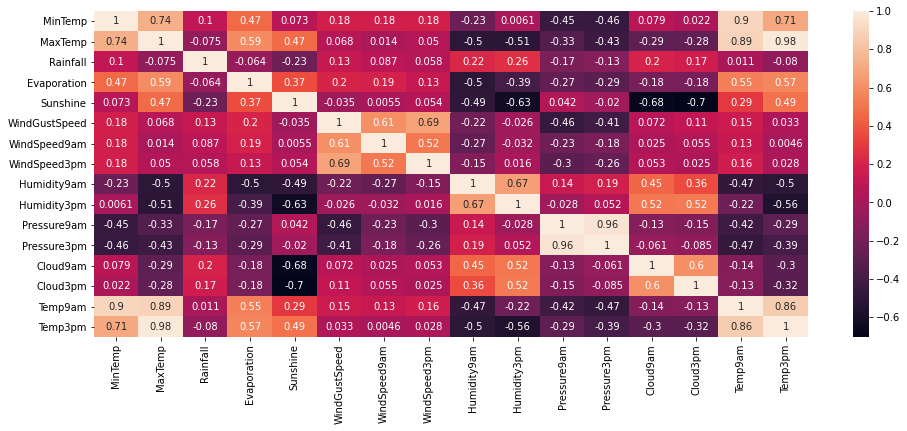

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(), annot=True )

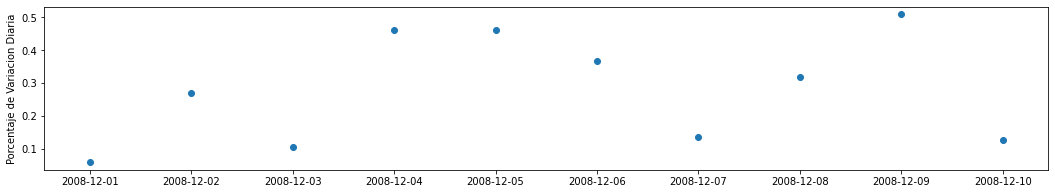

El porcentaje maximo de variacion diaria es 2%

In [ ]:
pressure_dif = abs(data.Pressure3pm - data.Pressure9am)/max(data.Pressure3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(data.Date[0:10], pressure_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(pressure_dif))))

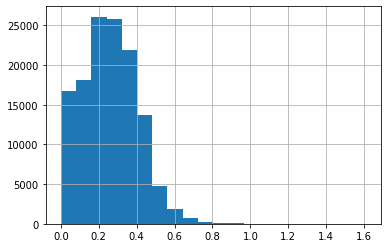

In [ ]:
pressure_dif.hist(bins=20)6

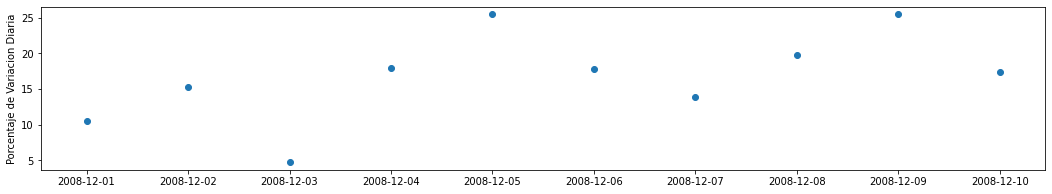

El porcentaje maximo de variacion diaria es 49%

In [ ]:
temp_dif = abs(data.Temp3pm - data.Temp9am)/max(data.Temp3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(data.Date[0:10], temp_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(temp_dif))))

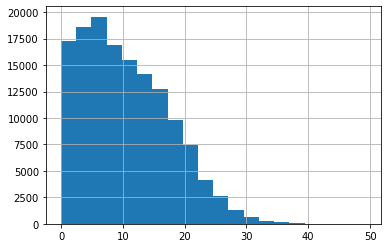

In [ ]:
temp_dif.hist(bins=20)

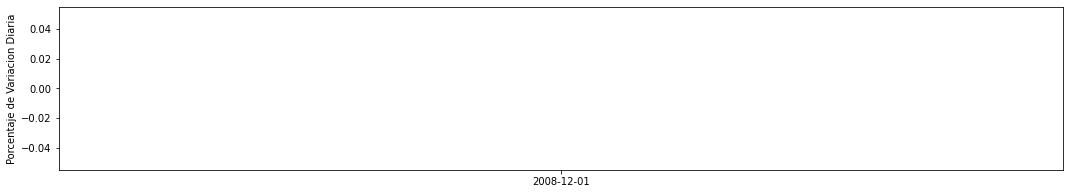

ValueError: ignored

In [ ]:
cloud_dif = abs(data.Cloud3pm - data.Cloud9am)/max(data.Cloud3pm)*100
plt.figure(figsize=(18, 3))
plt.scatter(data.Date[0:10], cloud_dif[0:10])
plt.ylabel('Porcentaje de Variacion Diaria')
plt.show()
md('El porcentaje maximo de variacion diaria es {}%'.format(round(max(cloud_dif))))

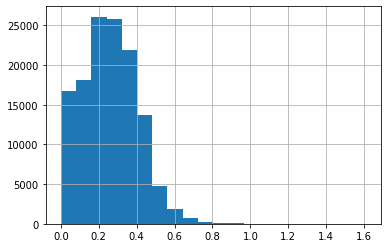

In [ ]:
pressure_dif.hist(bins=20)

Text(0.5, 1.0, 'Cardinalidad')

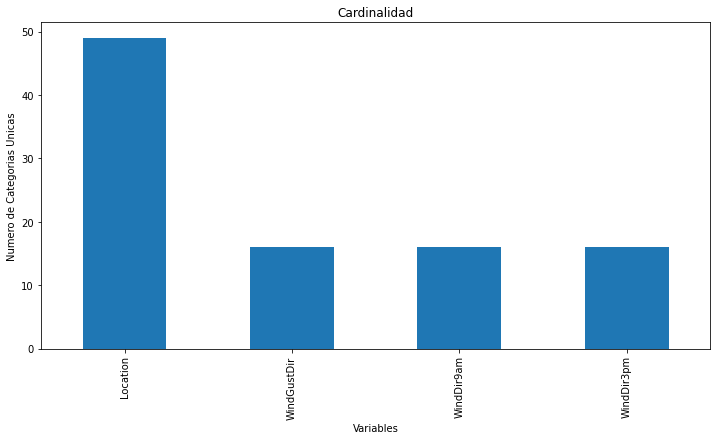

In [ ]:
data_cat = data[['Location','WindGustDir', 'WindDir9am', 'WindDir3pm']]
data_cat.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Numero de Categorias Unicas')
plt.xlabel('Variables')
plt.title('Cardinalidad')

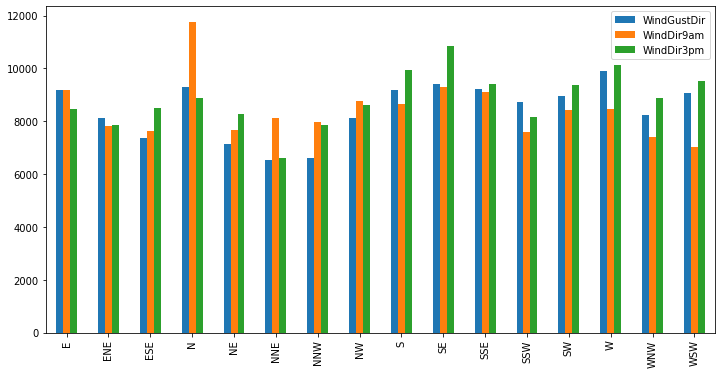

In [ ]:
data_wind = data_cat.drop(['Location'], axis=1)
data_wind.apply(pd.Series.value_counts).plot(figsize=(12,6), kind='bar', stacked=False)

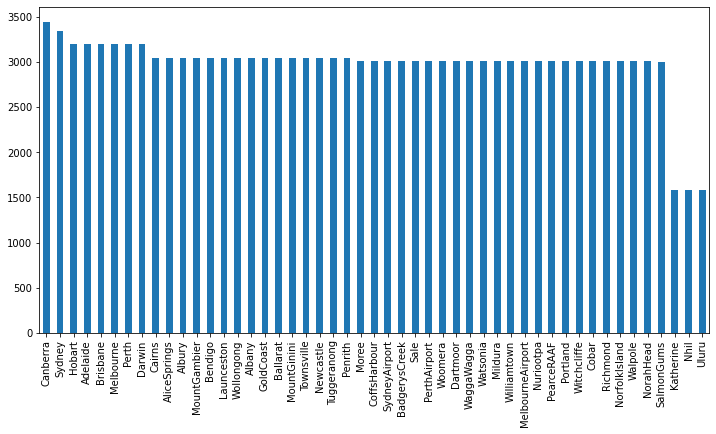

In [ ]:
data_cat.Location.value_counts().plot(figsize=(12,6), kind='bar', stacked=False)

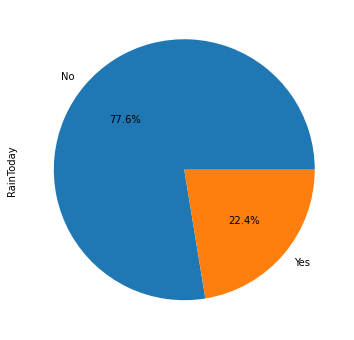

In [ ]:
data.RainToday.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

#### Variables de Salida

En el siguiente grafico de torta se observa un claro desbalance de clases en la variable de salida.

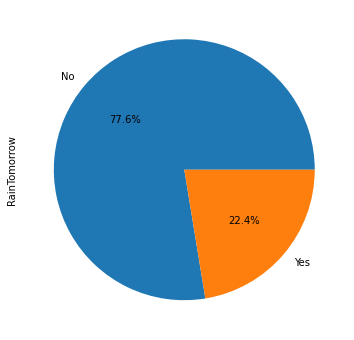

In [ ]:
data.RainTomorrow.value_counts().plot(figsize=(12,6), kind='pie', autopct='%1.1f%%')

In [ ]:
count = 0
for i in range(0, len(data.RainToday)):
  if data.RainToday[i] == data.RainTomorrow[i]:
    count = count + 1
percent = round(count/len(data.RainToday)*100, 2)


In [ ]:
md("Un {}% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia.".format(percent))

Un 73.78% de las observaciones, corresponde a casos en los que llovio al dia siguiente de un dia de lluvia.

Nos encontramos ante un caso de clasificacion con dos clases de salida, por lo que la solucion mas adecuada es un Binary Enconding, donde Yes=1 y No=0.

### 2. Esquema de validación de resultados

- Los pasos siguientes comprenden las etapas de preparación de datos y evaluación de resultados. 
- Para ello, se debe particionar el dataset en entrenamiento y validación.

### 3. Limpieza y preparación de datos / ingeniería de features

- Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable.
- ¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación recomendaría?. Ensayar distintas técnicas y analizar los resultados. 
- En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de datos compuestos o estructurados, considerar la obtención de variables de tipo númerico/categórico.
- ¿Qué puede decir acerca de las relaciones entre las variables de entrada?

- Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de entrada de mayor importancia?. Considerar por lo menos dos técnicas para cada variable. Explique brevemente los métodos utilizados.

### 4. Entrenamiento de modelos

- Recurriendo a los modelos que conozca, defina una lista de modelos candidatos a entrenar (puede ser el mismo tipo de clasificador con distintos hiperparámetros). Nota: no se contemplará el desempeño del modelo elegido, sino las conclusiones que puedan establecerse a partir de la preparación previa de los datos.

- Ensaye distintas cadenas de procesamiento con las técnicas consideradas en la sección 3 (por ejemplo, distintas técnicas de imputación, selección de variables de entrada, codificación de variables categóricas, transformación, etc.).

### 5. Evaluación de resultados y conclusiones

- ¿Qué puede concluir acerca de los modelos y preparaciones de datos ensayadas? Tener en cuenta como cada preparación afecta a los distintos modelos.

### 6. Presentación de resultados

- Elabore un informe de dos o tres páginas describiendo el procedimiento realizado y las conclusiones importantes indicando la ruta del código fuente en git.


### Insights
- Si consideramos un modelo constante, y predecimos lluvia para un dia considerando que llovio el dia anterior, entonces obtendremos un 73,78% de acierto aproximado en el set de entrenamiento.
- Analizar la varianza de las variables con varias mediciones en el dia y decidir si conviene considerarlas a todas o no (las distribuciones son muy similares para Pressure, Temperature and Cloud). Podria plotearse una linea de tiempo para evaluar su variacion en el dia. Para completar algunos analisis es necesario completar o resolver los nans.